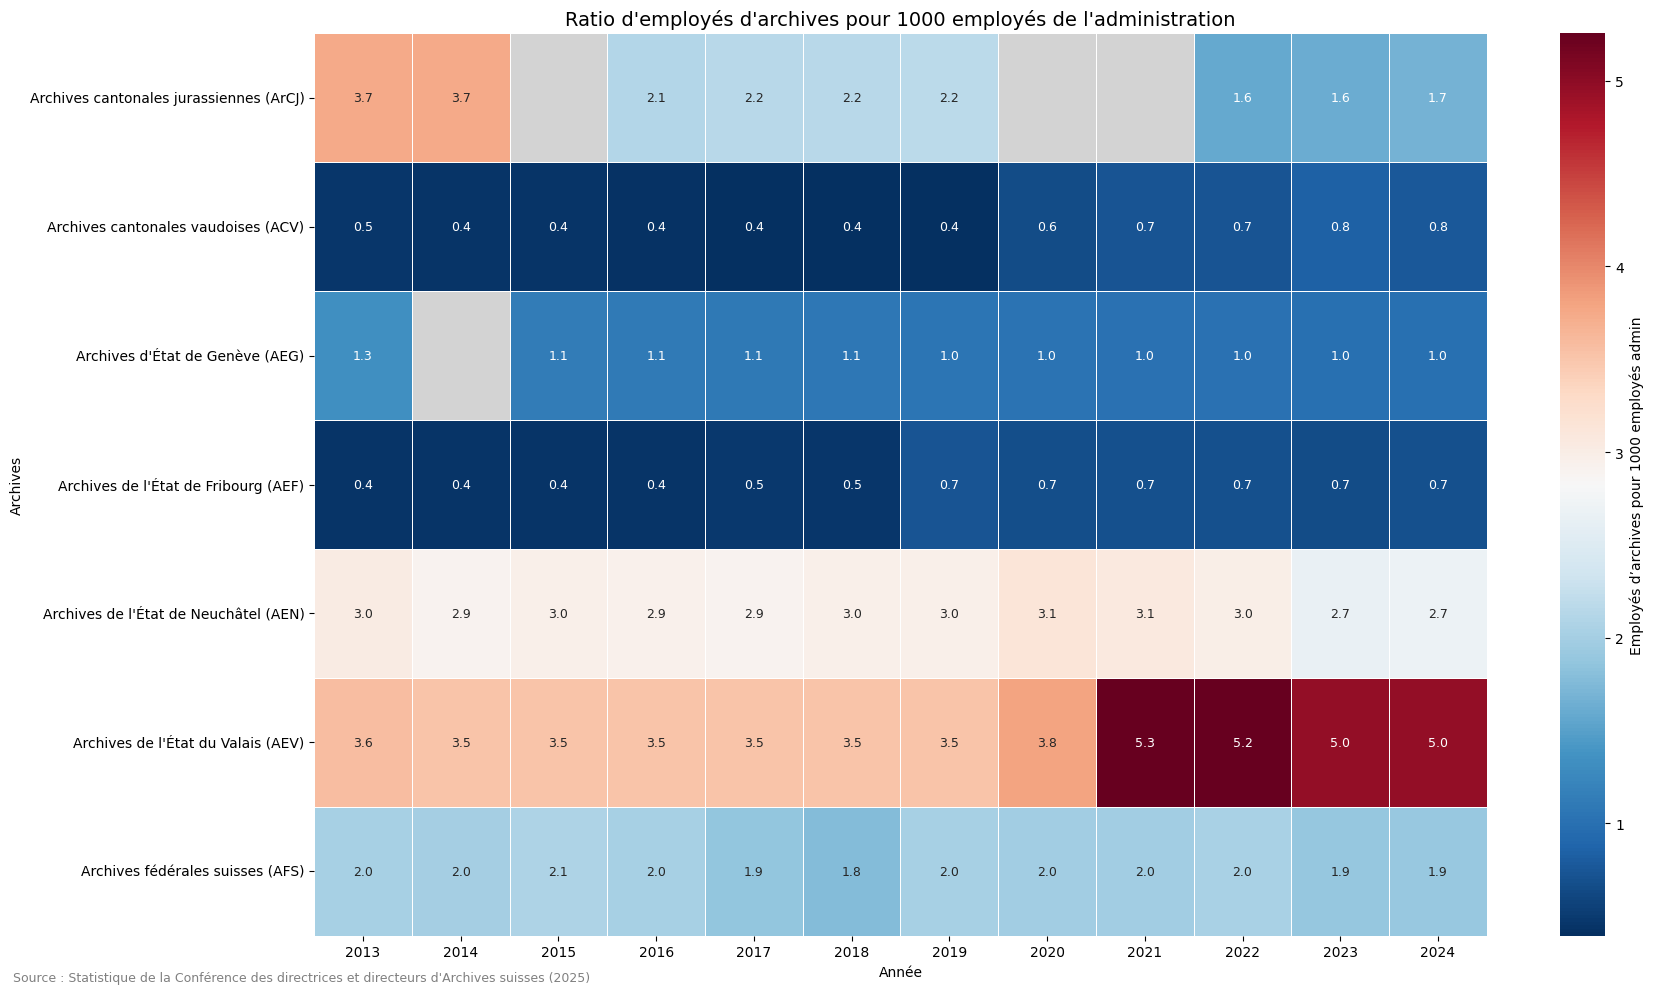

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Charger et préparer les données
df = pd.read_excel("statistiques_archives_suisses.xlsx")

df_clean = df[['archives', 'Date',
               "Nombre d’employés à durée indéterminée et à temps plein",
               "Nombre d’employés à durée indéterminée plein temps du service"]].copy()
df_clean.columns = ['Archives', 'Année', 'Employes_Archives', 'Employes_Admin']

# Types
df_clean['Année'] = pd.to_numeric(df_clean['Année'], errors='coerce')
df_clean['Employes_Archives'] = pd.to_numeric(df_clean['Employes_Archives'], errors='coerce')
df_clean['Employes_Admin'] = pd.to_numeric(df_clean['Employes_Admin'], errors='coerce')

# Supprimer les lignes inexploitables
df_clean = df_clean.dropna(subset=['Archives', 'Année', 'Employes_Archives', 'Employes_Admin'])

# 2) Calcul du ratio : employés d’archives pour 1000 employés d’administration
df_clean['Ratio_1000'] = (df_clean['Employes_Archives'] / df_clean['Employes_Admin']) * 1000

# 3) Tableau Année × Archives (on prendra la moyenne si plusieurs lignes par couple)
D = df_clean.pivot_table(index='Année', columns='Archives', values='Ratio_1000', aggfunc='mean')
D = D.sort_index()  # tri chronologique des années

# 4) Transposer pour la lecture (Archives en lignes, Années en colonnes)
D_T = D.transpose()

# 5) Masque pour les zéros (on n’affiche ni la valeur ni la couleur ; case gris clair)
mask = D_T.fillna(0) == 0

# 6) Heatmap
plt.figure(figsize=(18, 10))
ax = sns.heatmap(
    D_T,
    annot=True,          # valeurs affichées
    fmt=".1f",
    cmap="RdBu_r",       # bleu-rouge inversée
    linewidths=0.5,
    annot_kws={"fontsize": 9},
    mask=mask,
    cbar_kws={'label': "Employés d’archives pour 1000 employés admin"}
)

# Colorer les cases masquées (zéro) en gris
ax.set_facecolor('lightgray')

# Titres et axes
plt.title("Ratio d'employés d'archives pour 1000 employés de l'administration", fontsize=14)
plt.xlabel("Année")
plt.ylabel("Archives")

# Source
plt.figtext(
    0.01, 0.01,
    "Source : Statistique de la Conférence des directrices et directeurs d'Archives suisses (2025)",
    fontsize=9, ha='left', va='bottom', color='gray'
)

plt.tight_layout()
plt.show()

# # Option : sauvegarde
# plt.savefig("heatmap_ratio_archives_pour_1000_admin.png", dpi=300, bbox_inches="tight")


--- Test du Chi² (Année × Archives) ---
Chi² : 9.68 | ddl : 66 | p-value : 1
V de Cramér : 0.030


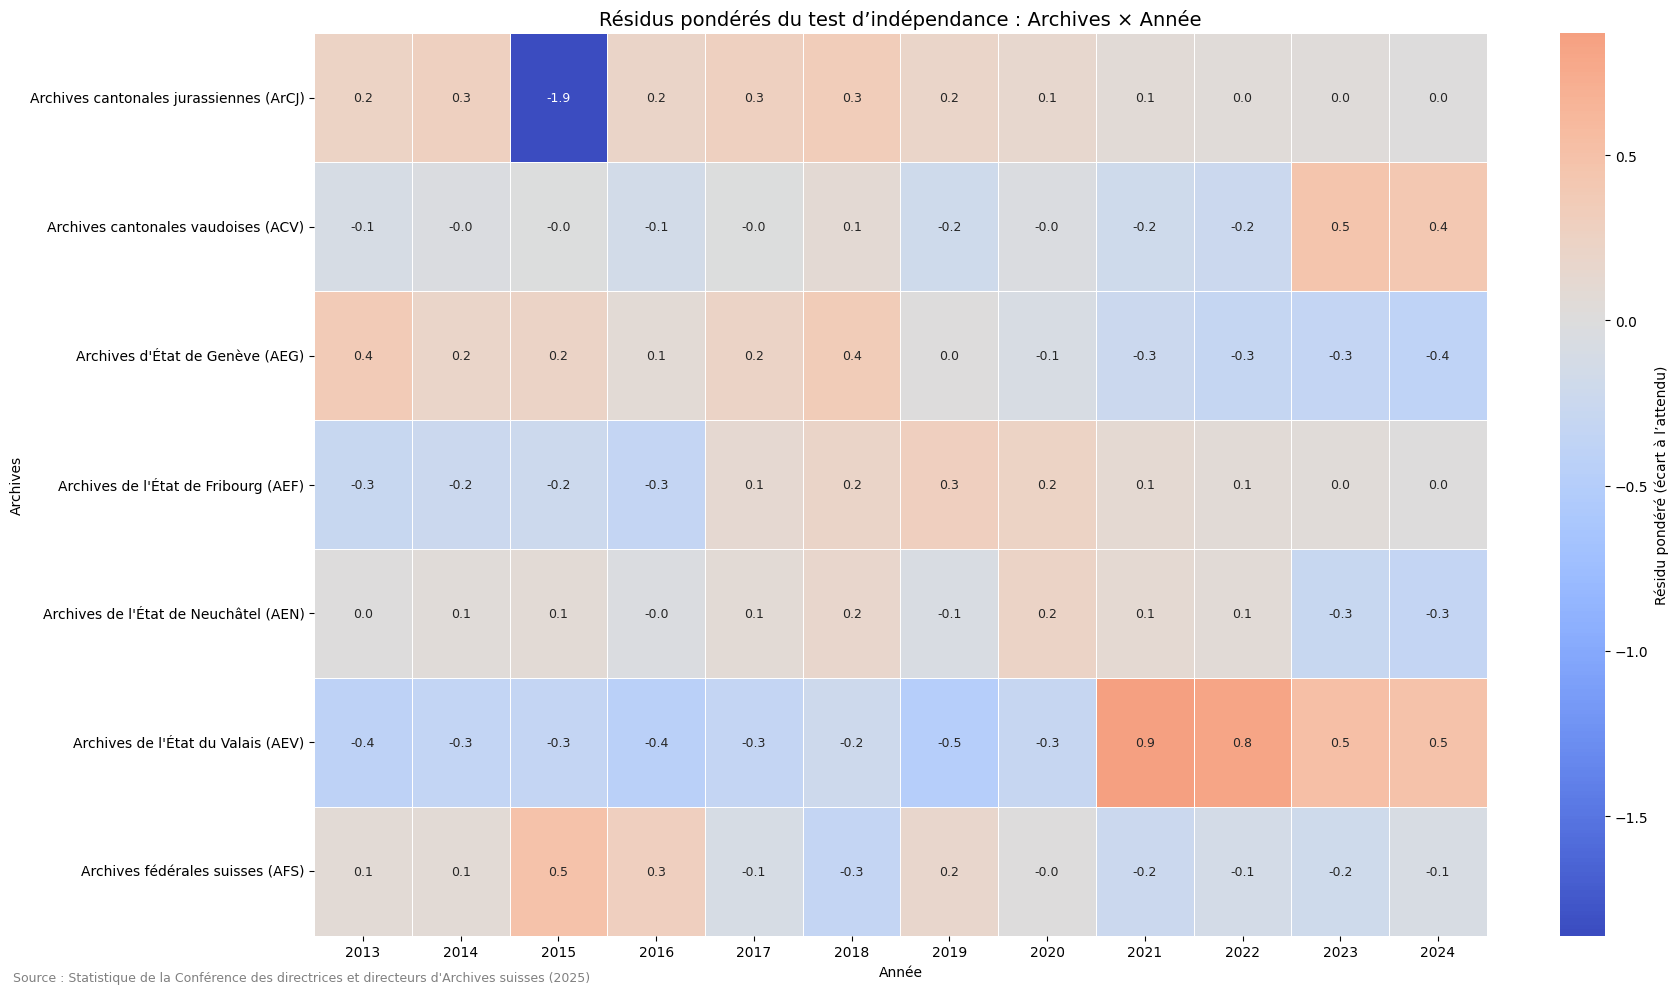

In [ ]:

"""
Chi² + V de Cramér + Heatmap des résidus pondérés
sur le tableau Année × Archives (effectifs d'archivistes).
"""

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# ==========
# 1) Chargement & préparation
# ==========
fichier = "statistiques_archives_suisses.xlsx"
df = pd.read_excel(fichier)

# Colonnes utilisées (adapter si besoin)
cols = [
    'archives', 'Date',
    "Nombre d’employés à durée indéterminée et à temps plein"
]
df_clean = df[cols].copy()
df_clean.columns = ['Archives', 'Année', 'Employes_Archives']

# Types & nettoyage minimal
df_clean['Année'] = pd.to_numeric(df_clean['Année'], errors='coerce')
df_clean['Employes_Archives'] = pd.to_numeric(df_clean['Employes_Archives'], errors='coerce')
df_clean = df_clean.dropna(subset=['Archives', 'Année', 'Employes_Archives'])

# ==========
# 2) Tableau Année × Archives (effectifs)
# ==========
D = df_clean.pivot_table(
    index='Année',
    columns='Archives',
    values='Employes_Archives',
    aggfunc='sum',
    fill_value=0
).astype(int).sort_index()

# Total des effectifs (pour V de Cramér)
n = D.to_numpy().sum()

# S'il n'y a pas de données exploitables
if n == 0 or D.shape[0] < 2 or D.shape[1] < 2:
    raise ValueError("Tableau insuffisant pour un Chi² (au moins 2 lignes et 2 colonnes non nulles).")

# ==========
# 3) Test du Chi² d’indépendance
# ==========
# (pas de correction de Yates au-delà du 2x2)
chi2_stat, p_value, dof, expected = chi2_contingency(D, correction=False)

# ==========
# 4) V de Cramér
# ==========
r, c = D.shape
k = min(r - 1, c - 1)
V = np.sqrt(chi2_stat / (n * k)) if (n > 0 and k > 0) else np.nan

print("--- Test du Chi² (Année × Archives) ---")
print(f"Chi² : {chi2_stat:.2f} | ddl : {dof} | p-value : {p_value:.4g}")
print(f"V de Cramér : {V:.3f}")

# ==========
# 5) Résidus pondérés (écart à l’attendu)
#    (observé - attendu) / sqrt(attendu)
# ==========
residus = (D - expected) / np.sqrt(expected)
residus = pd.DataFrame(residus, index=D.index, columns=D.columns)

# Pour lecture en heatmap : Archives en lignes, Années en colonnes
R = residus.transpose()

# ==========
# 6) Heatmap des résidus
#    (center=0 pour mettre en évidence les sur/sous-représentations)
# ==========
plt.figure(figsize=(18, 10))
ax = sns.heatmap(
    R, annot=True, fmt=".1f",
    cmap="coolwarm", center=0,
    linewidths=0.5,
    annot_kws={"fontsize": 9},
    cbar_kws={'label': "Résidu pondéré (écart à l’attendu)"}
)

plt.title("Résidus pondérés du test d’indépendance : Archives × Année", fontsize=14)
plt.xlabel("Année")
plt.ylabel("Archives")

plt.figtext(
    0.01, 0.01,
    "Source : Statistique de la Conférence des directrices et directeurs d'Archives suisses (2025)",
    fontsize=9, ha='left', va='bottom', color='gray'
)

plt.tight_layout()
plt.show()

# # Option : fixer l'échelle des couleurs pour comparabilité entre figures
# # ax.collections[0].colorbar.set_clim(-3, 3)
# # plt.savefig("heatmap_residus_pond_archives_annee.png", dpi=300, bbox_inches="tight")
